# Script to recreate results from the paper

### Load the required packages

In [1]:
library(Matrix)
library(GillespieSSA2)
library(doSNOW)
library(foreach)
library(ggpubr)
library(cowplot)

Loading required package: foreach

Loading required package: iterators

Loading required package: snow

Loading required package: ggplot2


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




### Create cluster to use foreach for parallel computation

In [2]:
num_cores = 10 # num. of cores to use
nboot <- 1000 # num. of cells to simulate
cl <- makeCluster(num_cores) # create clusters
registerDoSNOW(cl) # register clusters
clusterEvalQ(cl, .libPaths("/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"))
pb <- txtProgressBar(max = nboot, style = 3) # to display progress bars for parallel computation
progress <- function(n) setTxtProgressBar(pb, n) # to display progress bars for parallel computation
opts <- list(progress = progress) # to display progress bars for parallel computation

[[1]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[2]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[3]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[4]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[5]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[6]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[7]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[8]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[9]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"                                 

[[10]]
[1] "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"
[2] "/usr/local/lib/R/site-library"                      
[3] "/usr/lib/R/site-library"                            
[4] "/usr/lib/R/library"

  |                                                                      |   0%

## Simulations for the untreated case

### Setup simulation parameters and initial state

In [3]:
# reaction rates
rxn_rates = c(0.000208333, 0.002083333, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = floor((rxn_rates[5])/rxn_rates[6])*
              floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 10

### Run simulation using Gillespie's Direct Method (DM)

In [4]:
out.control <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}

  |======================================================================| 100%

### Close the cluster

In [112]:
close(pb)
stopCluster(cl)

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [5]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.control[[i]]$Protein[length(out.control[[i]]$Protein)]
}
mean_val <- mean(steady_state)

### Plot for single-cell trajectories protein count

In [26]:
col <- "gray20" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) + 
  geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

# Plot the first trajectory
# id <- which(out.control[[1]]$time >= skip_hours * 60 * 60)
# dat.plot <- data.frame(x = out.control[[1]]$time[id]/(60 * 60) - 
#                          min(out.control[[1]]$time[id]/(60 * 60)), 
#                         y = out.control[[1]]$Protein[id]/10^5)
# p <- ggline(dat.plot, x = "x", y = "y", 
#             numeric.x.axis = T, 
#             linetype = "solid",
#             plot_type = c("l"),
#             fill = col,           
#             color = col,
#             sort.by.groups = FALSE,
#             x.text.angle = 0,
#             ylab = expression(atop("Gene product", 
#                                    "(molecules" %*% "10"^"5"*")")),
#             xlab = "Time (hrs)",
#             # legend = "bottom",
#             legend.title = "",
#             y.text.angle = 0,
#             rotate = F,
#             font.x = 14, 
#             font.y = 14,
#             font.tickslab = 13,
#             size = 0.9,
#             point.size = 0.1,
#             # font.label = 14,
#             theme = theme_pubr()
# )

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.control[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.control[[b]]$time[id]/(60 * 60) - 
                           min(out.control[[1]]$time[id]/(60 * 60)), 
                         y = out.control[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.9)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean(steady_state)/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
p <- p + 
geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
            mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(), 
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.control.time <- p +  ggtitle("Untreated")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [16]:
# y-axis limit
ymax <- 80
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x),
                 color="black", fill="black", bins = 100) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean(steady_state)/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Visually explain the concept of noise
p <- p + geom_segment(aes(x = 0, y = ymid, 
                          xend = 0.3, yend = ymid),
                      arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
p <- p + geom_segment(aes(x = 1.3, y = ymax/2, 
                          xend = 1, yend = ymid),
                      arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
  geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.control.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

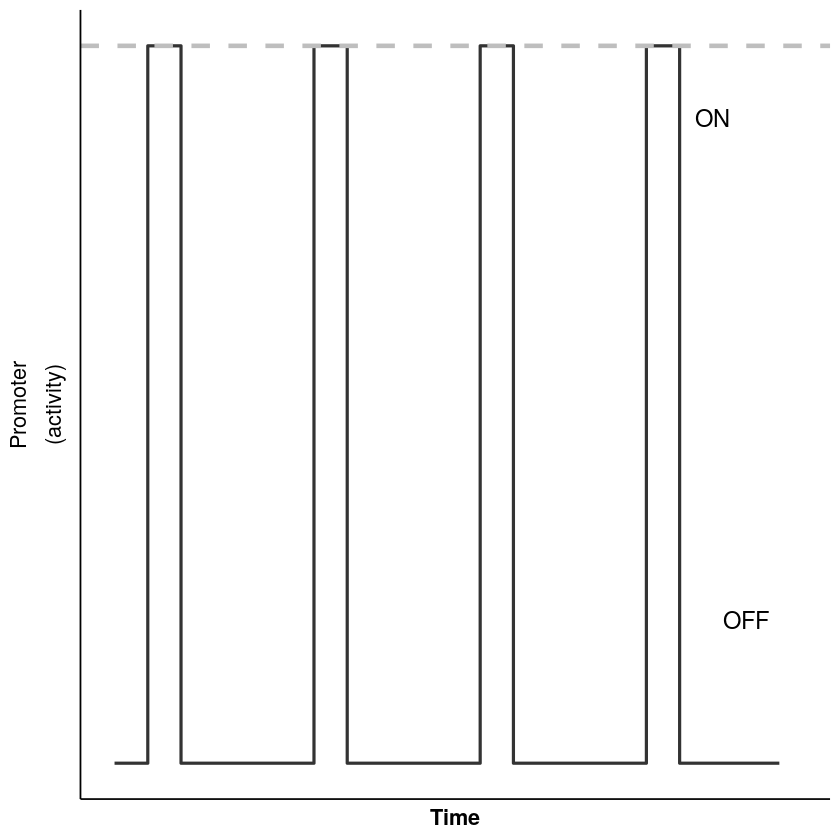

In [18]:
on_frac = (params['kon'])/(params['kon'] + params['koff'])
col <- "gray20" # color for the single-cell time trajectories

# Plot the first trajectory
id <- which(out.control[[1]]$time >= skip_hours * 60 * 60)
dat.plot <- data.frame(x = c(0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 7, 7, 8, 9, 10, 11, 11, 12, 12, 
                            13, 14, 15, 16, 16, 17, 17, 18, 19, 20), 
                        y = c(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 
                             0, 0, 0, 0, 1, 1, 0, 0, 0, 0))
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "(activity)")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.9,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 1.3)

p <- p  + 
  geom_text(data = data.frame(x = 18, y = 0.9, label = "ON"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5) + 
geom_text(data = data.frame(x = 19, y = 0.2, label = "OFF"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 20.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.control.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.control.time, p.control.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.5, 1))
second.row <- plot_grid(p.control.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.5, 1))
plot.control <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_control.pdf", plot.control, base_height = 4, base_width = 6)
print(plot.control)

## Simulations for noise enhancer

### Setup simulation parameters and initial state

In [29]:
# reaction rates
rxn_rates = c(0.000104167, 0.001041667, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [30]:
out.NE <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.control[[b]]$Protein[length(out.control[[b]]$Protein)])  
    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [31]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.NE[[i]]$Protein[length(out.NE[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [32]:
col <- "purple" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Plot the first trajectory
# id <- which(out.NE[[1]]$time >= skip_hours * 60 * 60)
# dat.plot <- data.frame(x = out.NE[[1]]$time[id]/(60 * 60) - 
#                          min(out.NE[[1]]$time[id]/(60 * 60)), 
#                         y = out.NE[[1]]$Protein[id]/10^5)
# p <- ggline(dat.plot, x = "x", y = "y", 
#             numeric.x.axis = T, 
#             linetype = "solid",
#             plot_type = c("l"),
#             fill = col,           
#             color = col,
#             sort.by.groups = FALSE,
#             x.text.angle = 0,
#             ylab = expression(atop("Gene product", 
#                                    "(molecules" %*% "10"^"5"*")")),
#             xlab = "Time (hrs)",
#             # legend = "bottom",
#             legend.title = "",
#             y.text.angle = 0,
#             rotate = F,
#             font.x = 14, 
#             font.y = 14,
#             font.tickslab = 13,
#             size = 0.9,
#             point.size = 0.1,
#             # font.label = 14,
#             theme = theme_pubr()
# )

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.NE[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.NE[[b]]$time[id]/(60 * 60) - 
                           min(out.NE[[1]]$time[id]/(60 * 60)), 
                         y = out.NE[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.9)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
p <- p + 
geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
            mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.NE.time <- p +  ggtitle("Noise enhancer")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [36]:
# y-axis limit
ymax <- 100
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x=x), color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)



# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.NE.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

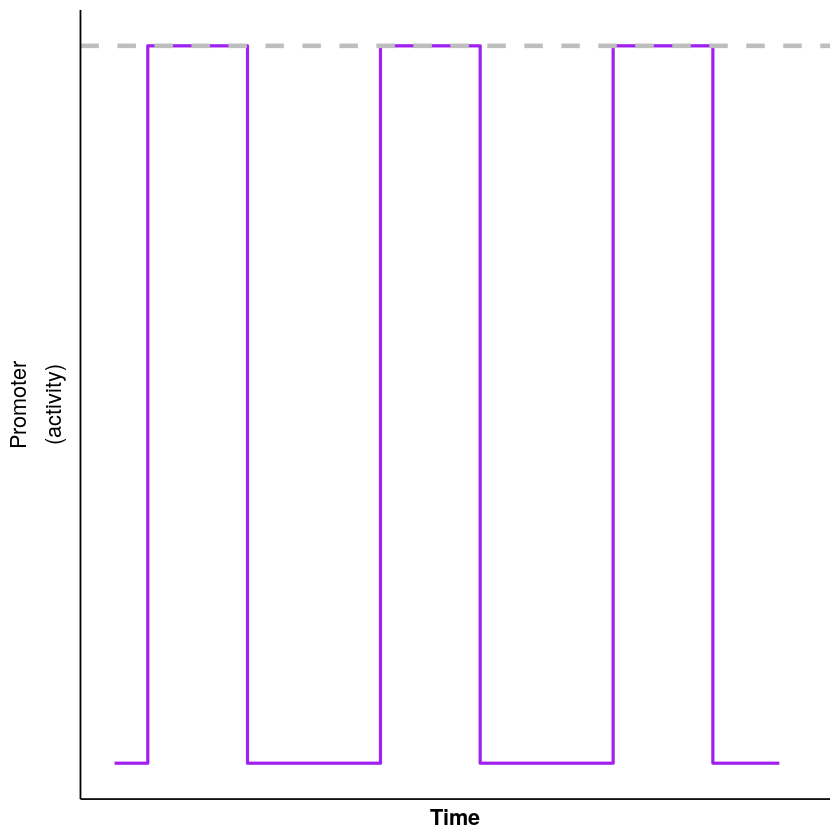

In [76]:
on_frac = (params['kon'])/(params['kon'] + params['koff'])
col <- "purple" # color for the single-cell time trajectories

# Plot the first trajectory
id <- which(out.NE[[1]]$time >= skip_hours * 60 * 60)
dat.plot <- data.frame(x = c(0, 1, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 10, 11, 11, 
                            12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20), 
                        y = c(0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 
                             0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0))
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "(activity)")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.9,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 1.3)

# p <- p  + 
#   geom_text(data = data.frame(x = 19, y = 0.9, label = "ON"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5) + 
# geom_text(data = data.frame(x = 19, y = 0.2, label = "OFF"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 20.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.NE.promoter <- p
print(p)

### Combine Plots

In [ ]:
first.row <- plot_grid(p.NE.time, p.NE.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.5, 1))
second.row <- plot_grid(p.NE.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.5, 1))
plot.NE <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_NE.png", plot.NE, base_height = 4, base_width = 6)
print(plot.NE)

## Simulations for activator

### Setup simulation parameters and initial state

In [41]:
# reaction rates
rxn_rates = c(0.000625, 0.002083, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [42]:
out.Ac <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.control[[b]]$Protein[length(out.control[[b]]$Protein)])    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [43]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.Ac[[i]]$Protein[length(out.Ac[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [46]:
col <- "blue" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Plot the first trajectory
# id <- which(out.Ac[[1]]$time >= skip_hours * 60 * 60)
# dat.plot <- data.frame(x = out.Ac[[1]]$time[id]/(60 * 60) - 
#                          min(out.Ac[[1]]$time[id]/(60 * 60)), 
#                         y = out.Ac[[1]]$Protein[id]/10^5)
# p <- ggline(dat.plot, x = "x", y = "y", 
#             numeric.x.axis = T, 
#             linetype = "solid",
#             plot_type = c("l"),
#             fill = col,           
#             color = col,
#             sort.by.groups = FALSE,
#             x.text.angle = 0,
#             ylab = expression(atop("Gene product", 
#                                    "(molecules" %*% "10"^"5"*")")),
#             xlab = "Time (hrs)",
#             # legend = "bottom",
#             legend.title = "",
#             y.text.angle = 0,
#             rotate = F,
#             font.x = 14, 
#             font.y = 14,
#             font.tickslab = 13,
#             size = 0.9,
#             point.size = 0.1,
#             # font.label = 14,
#             theme = theme_pubr()
# )

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.Ac[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.Ac[[b]]$time[id]/(60 * 60) - 
                           min(out.Ac[[1]]$time[id]/(60 * 60)), 
                         y = out.Ac[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.9)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
# p <- p + 
# geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.Ac.time <- p +  ggtitle("Activator")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [69]:
# y-axis limit
ymax <- 90
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x), 
                 color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)


# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.Ac.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

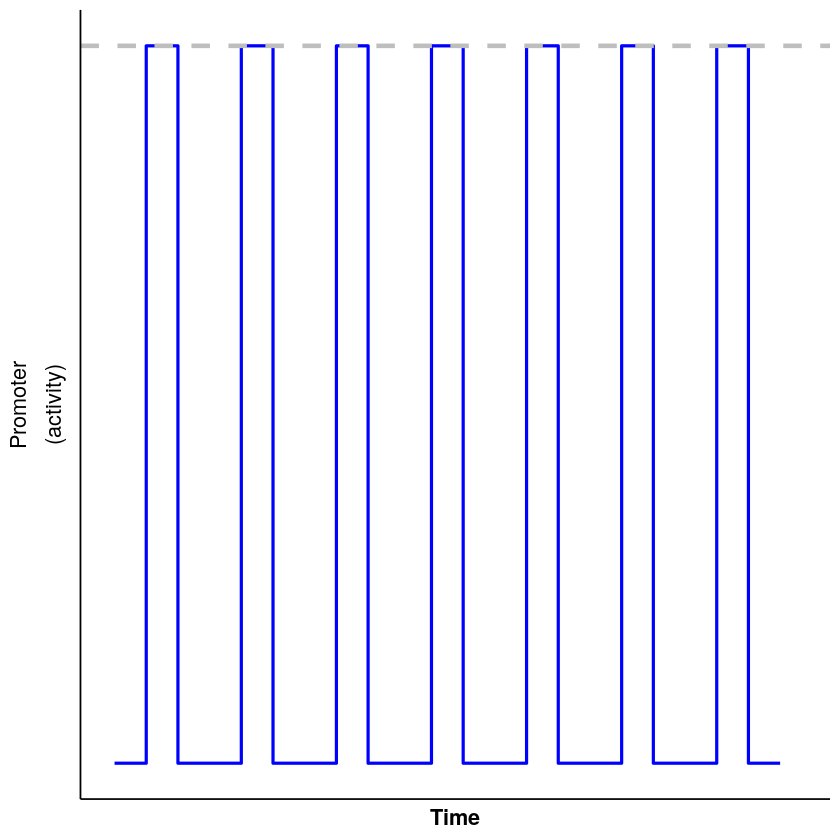

In [73]:
on_frac = (params['kon'])/(params['kon'] + params['koff'])
col <- "blue" # color for the single-cell time trajectories

# Plot the first trajectory
id <- which(out.Ac[[1]]$time >= skip_hours * 60 * 60)
dat.plot <- data.frame(x = c(0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 
                            11, 11, 12, 13, 13, 14, 14, 15, 16, 16, 17, 17, 18, 19, 19, 
                            20, 20, 21), 
                        y = c(0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 
                             1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0))
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "(activity)")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.9,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 1.3)

# p <- p  + 
#   geom_text(data = data.frame(x = 20.5, y = 0.9, label = "ON"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5) + 
# geom_text(data = data.frame(x = 20.5, y = 0.2, label = "OFF"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 21.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.Ac.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.Ac.time, p.Ac.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.5, 1))
second.row <- plot_grid(p.Ac.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.5, 1))
plot.Ac <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_Ac.pdf", plot.Ac, base_height = 4, base_width = 6)
print(plot.Ac)

## Simulations for activator + enhancer

### Setup simulation parameters and initial state

In [80]:
# reaction rates
rxn_rates = c(0.000625, 0.001041667, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [81]:
out.Ac_NE <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.NE[[b]]$Protein[length(out.NE[[b]]$Protein)])    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [88]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.Ac_NE[[i]]$Protein[length(out.Ac_NE[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [85]:
col <- "red" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Plot the first trajectory
# id <- which(out.Ac_NE[[1]]$time >= skip_hours * 60 * 60)
# dat.plot <- data.frame(x = out.Ac_NE[[1]]$time[id]/(60 * 60) - 
#                          min(out.Ac_NE[[1]]$time[id]/(60 * 60)), 
#                         y = out.Ac_NE[[1]]$Protein[id]/10^5)
# p <- ggline(dat.plot, x = "x", y = "y", 
#             numeric.x.axis = T, 
#             linetype = "solid",
#             plot_type = c("l"),
#             fill = col,           
#             color = col,
#             sort.by.groups = FALSE,
#             x.text.angle = 0,
#             ylab = expression(atop("Gene product", 
#                                    "(molecules" %*% "10"^"5"*")")),
#             xlab = "Time (hrs)",
#             # legend = "bottom",
#             legend.title = "",
#             y.text.angle = 0,
#             rotate = F,
#             font.x = 14, 
#             font.y = 14,
#             font.tickslab = 13,
#             size = 0.9,
#             point.size = 0.1,
#             # font.label = 14,
#             theme = theme_pubr()
# )

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.Ac_NE[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.Ac_NE[[b]]$time[id]/(60 * 60) - 
                           min(out.Ac_NE[[1]]$time[id]/(60 * 60)), 
                         y = out.Ac_NE[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.9)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
# p <- p + 
# geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.Ac_NE.time <- p +  ggtitle("Activator + noise enhancer")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [92]:
# y-axis limit
ymax <- 70
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x), 
                 color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)


# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.Ac_NE.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

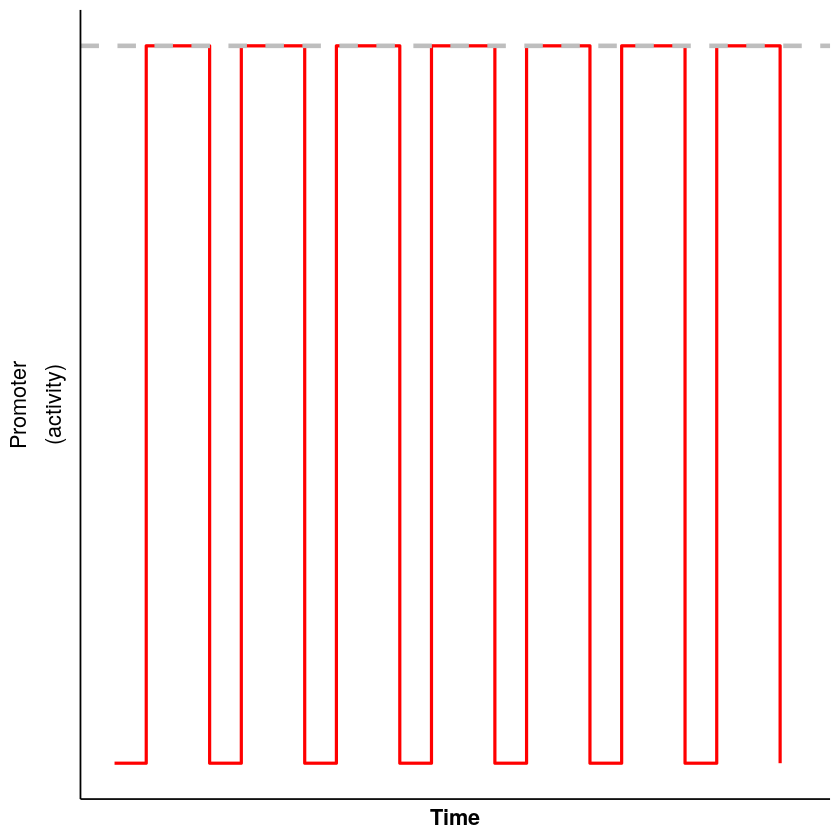

In [94]:
on_frac = (params['kon'])/(params['kon'] + params['koff'])
col <- "red" # color for the single-cell time trajectories

# Plot the first trajectory
id <- which(out.Ac_NE[[1]]$time >= skip_hours * 60 * 60)
dat.plot <- data.frame(x = c(0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 
                            10, 10, 11, 12, 12, 13, 13, 14, 15, 15, 16, 16, 
                            17, 18, 18, 19, 19, 20, 21, 21), 
                        y = c(0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 
                             0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 
                             1, 1, 0, 0, 1, 1, 1, 0))
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "(activity)")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.9,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 1.3)

# p <- p  + 
#   geom_text(data = data.frame(x = 20.5, y = 0.9, label = "ON"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5) + 
# geom_text(data = data.frame(x = 20.5, y = 0.2, label = "OFF"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 21.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.Ac_NE.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.Ac_NE.time, p.Ac_NE.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.5, 1))
second.row <- plot_grid(p.Ac_NE.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.5, 1))
plot.Ac_NE <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_Ac_NE.pdf", plot.Ac_NE, base_height = 4, base_width = 6)
print(plot.Ac_NE)